## Tratamiento de datos para modelo de evolución bursátil por fundamentales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 50

Los ficheros que vamos a tratar se han obtenido de la web simfin https://simfin.com/data/bulk, que proporciona datos de compañías cotizadas en EEUU desde 2007.
Nos descargamos 5 ficheros (10_6_20) con los datos de cotización, industrias, datos de compañías, balance y cuenta de resultados. Estas dos últimas solo para bancos, ya que el formato de sus cuentas es diferente al resto de compañías.

In [3]:
! ls -1 ./datos

DJUSFN.csv
industries.csv
us-balance-banks-quarterly.csv
us-companies.csv
us-income-banks-quarterly.csv
us-shareprices-daily.csv


In [4]:
! head ./datos/us-companies.csv

Ticker;SimFinId;"Company Name";IndustryId
GOOG;18;Alphabet;101002
FOX_old;242;"21st Century Fox";103001
ATVI;243;"Activision Blizzard";101003
ADBE;14099;"Adobe Systems";101003
MMM;22219;"3M CO";100001
TWTR;30388;"TWITTER, INC.";101002
BRID;33021;"BRIDGFORD FOODS CORP";102002
NWY;33184;"New York & Company, Inc.";103002
AMSC;33387;"AMERICAN SUPERCONDUCTOR CORP /DE/";101001


In [5]:
! head ./datos/us-shareprices-daily.csv

Ticker;SimFinId;Date;Open;Low;High;Close;"Adj. Close";Dividend;Volume
GOOG;18;2007-01-03;115.9490;114.7323;118.6014;116.3447;232.92;;15470700
GOOG;18;2007-01-04;116.6955;116.5337;120.4153;120.2436;240.73;;15834200
GOOG;18;2007-01-05;120.0545;118.9622;121.2986;121.2214;242.69;;13795600
GOOG;18;2007-01-08;121.3459;119.9799;121.8883;120.3232;240.89;;9544400
GOOG;18;2007-01-09;120.7885;119.7310;121.4852;120.8009;241.84;;10803000
GOOG;18;2007-01-10;120.5347;119.9401;122.8039;121.7863;243.82;;11981700
GOOG;18;2007-01-11;123.7121;123.4583;124.8443;124.3392;248.93;;14470400
GOOG;18;2007-01-12;124.9039;124.4088;125.6529;125.6529;251.56;;8980800
GOOG;18;2007-01-16;126.2874;125.2299;127.6435;125.4737;251.20;;15194500


In [4]:
balance = pd.read_csv('./datos/us-balance-banks-quarterly.csv', sep=';')
resultados = pd.read_csv('./datos/us-income-banks-quarterly.csv', sep=';', 
                         usecols=['Ticker','Fiscal Year','Fiscal Period', 'Revenue',
                                  'Provision for Loan Losses', 'Net Revenue after Provisions',
                                  'Total Non-Interest Expense', 'Operating Income (Loss)',
                                  'Non-Operating Income (Loss)', 'Pretax Income (Loss)',
                                  'Income Tax (Expense) Benefit, Net', 'Income (Loss) from Continuing Operations',
                                  'Net Extraordinary Gains (Losses)', 'Net Income', 'Net Income (Common)'])
industries = pd.read_csv('./datos/industries.csv', sep=';', dtype='str')
companies = pd.read_csv('./datos/us-companies.csv', sep=';', dtype='str')
cotizacion = pd.read_csv('./datos/us-shareprices-daily.csv', sep=';', date_parser='Dates')
# Utilizamos dtype en companies e industries para convertir los códigos numéricos en caracteres, pero ralentiza
# mucho la lectura. Habría que mirar alternativas.

In [5]:
#Identificamos el código industrial 'IndustryId' correspondiente al sector bancario
industries.Sector.unique()

array(['Industrials', 'Technology', 'Consumer Defensive',
       'Consumer Cyclical', 'Financial Services', 'Utilities',
       'Healthcare', 'Energy', 'Business Services', 'Real Estate',
       'Basic Materials', 'Other'], dtype=object)

In [6]:
industries[industries.Sector=='Financial Services']

,IndustryId,Sector,Industry
35,104001,Financial Services,Asset Management
36,104002,Financial Services,Banks
37,104003,Financial Services,Brokers & Exchanges
38,104004,Financial Services,Insurance - Life
39,104005,Financial Services,Insurance
40,104006,Financial Services,Insurance - Property & Casualty
41,104007,Financial Services,Credit Services
42,104013,Financial Services,Insurance - Specialty


In [7]:
companies.head(1)

,Ticker,SimFinId,Company Name,IndustryId
0,GOOG,18,Alphabet,101002


In [8]:
# De la tabla de compañías, nos quedamos únicamente con los bancos
banks = companies[companies.IndustryId=='104002']
print(banks.count())
banks.head()

Ticker          57
SimFinId        57
Company Name    57
IndustryId      57
dtype: int64


,Ticker,SimFinId,Company Name,IndustryId
91,GS,60439,GOLDMAN SACHS GROUP INC,104002
138,BAC,71941,BANK OF AMERICA CORP /DE/,104002
190,C,89126,CITIGROUP INC,104002
330,IBKC,129297,IBERIABANK CORP,104002
331,NKSH,129536,NATIONAL BANKSHARES INC,104002


In [9]:
cotizacion.head()

,Ticker,SimFinId,Date,Open,Low,High,Close,Adj. Close,Dividend,Volume
0,GOOG,18,2007-01-03,115.9490,114.7323,118.6014,116.3447,232.92,NaN,15470700
1,GOOG,18,2007-01-04,116.6955,116.5337,120.4153,120.2436,240.73,NaN,15834200
2,GOOG,18,2007-01-05,120.0545,118.9622,121.2986,121.2214,242.69,NaN,13795600
3,GOOG,18,2007-01-08,121.3459,119.9799,121.8883,120.3232,240.89,NaN,9544400
4,GOOG,18,2007-01-09,120.7885,119.7310,121.4852,120.8009,241.84,NaN,10803000


In [10]:
#Filtramos la tabla de cotizaciones únicamente con los bancos y exploramos un poco el resultado para ver
# cuantas compañías disponen de cotizaciones diarias para la serie completa 2007-01-03 -- 2019-06-07

banks_cotiz = cotizacion[cotizacion.Ticker.isin(banks.Ticker)]

# Tenemos que reiniciar el índice
banks_cotiz.reset_index(inplace=True)
banks_cotiz=banks_cotiz.drop('index', axis=1)

# Vemos que son 43 bancos
banks_cotiz.groupby('Ticker').count()[banks_cotiz.groupby('Ticker').count().Close == 3129].count()

SimFinId      43
Date          43
Open          43
Low           43
High          43
Close         43
Adj. Close    43
Dividend      43
Volume        43
dtype: int64

Con 43 bancos desde enero del 2007 hasta junio de 2019, si hacemos ventanas temporales trimestrales, en principio contaríamos con una población para alimentar el modelo de (12*4 + 1)*43 = 2.107

A continuación verificamos la disponibilidad de información contable para estos bancos.

In [11]:
# Creamos una nueva tabla de datos de balance con los bancos para los cuales disponemos cotización
balance_filtrado = balance[balance['Ticker'].isin(banks_cotiz.Ticker)]

In [12]:
# Aquí contamos el número de datos trimestrales disponibles.
exp = balance_filtrado.groupby('Ticker').Currency.count()
len(exp[exp>31])

35

In [13]:
# Creamos una nueva tabla de datos de pyg con los bancos para los cuales disponemos cotización
resultados_filtrado = resultados[resultados['Ticker'].isin(banks_cotiz.Ticker)]

In [14]:
# Aquí contamos el número de datos trimestrales disponibles, obteniendo 35 empresas con 31 datos trimestrales.
# Utilizando solo estos datos dispondríamos de una población de 1.085 registros.
exp = resultados_filtrado.groupby('Ticker').Revenue.count()
len(exp[exp>31])

35

A continuación, debemos generar una tabla única en la que se encuentre incorporado el mayor número posible de datos contables y con el dato de cotización al final del periodo. Aquí tenemos una limitación, y es que en realidad, la información contable al cierre de un trimestre no está disponible en ese mismo momento. Como simplificación del modelo podemos utilizar la cotización del final del periodo, o, alternativamente, utilizar la fecha de report (!que está disponible!). En cualquiera de las dos alternativas, el plazo de análisis de evolución de la cotización será de tres meses.

In [15]:
balance_filtrado

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),"Cash, Cash Equivalents & Short Term Investments",Interbank Assets,Short & Long Term Investments,Accounts & Notes Receivable,Net Loans,Net Fixed Assets,Total Assets,Total Deposits,Short Term Debt,Long Term Debt,Total Liabilities,Preferred Equity,Share Capital & Additional Paid-In Capital,Treasury Stock,Retained Earnings,Total Equity,Total Liabilities & Equity
90,BAC,71941,USD,2011,Q3,2011-09-30,2011-11-03,2011-11-03,1.011628e+10,1.046440e+10,82865000000,2.499980e+11,624497000000,NaN,8.974490e+11,1.355200e+10,2219628000000,1.041353e+12,3.500110e+11,3.989650e+11,1989376000000,1.948000e+10,153801000000,NaN,5.904300e+10,230252000000,2219628000000
91,BAC,71941,USD,2011,Q4,2011-12-31,2012-02-23,2013-02-28,1.028341e+10,1.027862e+10,120102000000,2.111830e+11,579762000000,NaN,8.924170e+11,1.363700e+10,2129046000000,1.033041e+12,3.110700e+11,3.722650e+11,1898945000000,1.839700e+10,156621000000,NaN,6.052000e+10,230101000000,2129046000000
92,BAC,71941,USD,2012,Q1,2012-03-31,2012-05-03,2012-05-03,1.065137e+10,1.076192e+10,128792000000,2.257840e+11,620550000000,NaN,8.700830e+11,1.310400e+10,2181449000000,1.041311e+12,3.681590e+11,3.549120e+11,1948950000000,1.878800e+10,157973000000,NaN,6.073400e+10,232499000000,2181449000000
93,BAC,71941,USD,2012,Q2,2012-06-30,2012-08-02,2012-08-02,1.077570e+10,1.155601e+10,123717000000,2.261160e+11,622231000000,NaN,8.620270e+11,1.265300e+10,2160854000000,1.035225e+12,4.023910e+11,3.018480e+11,1924879000000,1.876200e+10,158001000000,NaN,6.271200e+10,235975000000,2160854000000
94,BAC,71941,USD,2012,Q3,2012-09-30,2012-11-02,2012-11-02,1.077617e+10,1.077617e+10,106415000000,2.340340e+11,630752000000,NaN,8.668020e+11,1.243600e+10,2166162000000,1.063307e+12,3.813700e+11,2.865340e+11,1927556000000,1.876800e+10,158066000000,NaN,6.258300e+10,238606000000,2166162000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050,ZION,378250,USD,2018,Q1,2018-03-31,2018-05-09,2018-05-09,1.967220e+08,2.102430e+08,470000000,1.413000e+09,15807000000,NaN,4.461000e+10,1.098000e+09,66481000000,5.296300e+10,4.867000e+09,3.830000e+08,58837000000,5.660000e+08,4346000000,NaN,2.999000e+09,7644000000,66481000000
2051,ZION,378250,USD,2018,Q2,2018-06-30,2018-08-08,2018-08-08,1.955830e+08,2.092470e+08,468000000,1.256000e+09,15712000000,NaN,4.474000e+10,1.099000e+09,66457000000,5.358000e+10,4.158000e+09,3.830000e+08,58836000000,5.660000e+08,4231000000,NaN,3.139000e+09,7621000000,66457000000
2052,ZION,378250,USD,2018,Q3,2018-09-30,2018-11-07,2018-11-07,1.929730e+08,2.057650e+08,517000000,1.150000e+09,15552000000,NaN,4.533000e+10,1.111000e+09,66731000000,5.378500e+10,3.780000e+09,8.790000e+08,59178000000,5.660000e+08,4052000000,NaN,3.296000e+09,7553000000,66731000000
2053,ZION,378250,USD,2018,Q4,2018-12-31,2019-02-26,2019-05-08,1.890780e+08,2.007490e+08,614000000,2.080000e+09,15617000000,NaN,4.621900e+10,1.124000e+09,68746000000,5.410100e+10,5.653000e+09,7.240000e+08,61168000000,5.660000e+08,3806000000,NaN,3.456000e+09,7578000000,68746000000


In [16]:
resultados_filtrado.tail(6)

,Ticker,Fiscal Year,Fiscal Period,Revenue,Provision for Loan Losses,Net Revenue after Provisions,Total Non-Interest Expense,Operating Income (Loss),Non-Operating Income (Loss),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common)
2049,ZION,2017,Q4,667000000,11000000.0,678000000,-417000000,261000000,NaN,261000000,-136000000.0,125000000,NaN,125000000,117000000
2050,ZION,2018,Q1,680000000,40000000.0,720000000,-412000000,308000000,NaN,308000000,-70000000.0,238000000,NaN,238000000,231000000
2051,ZION,2018,Q2,686000000,-5000000.0,681000000,-428000000,253000000,NaN,253000000,-56000000.0,197000000,NaN,197000000,187000000
2052,ZION,2018,Q3,701000000,11000000.0,712000000,-418000000,294000000,NaN,294000000,-69000000.0,225000000,NaN,225000000,217000000
2053,ZION,2018,Q4,715000000,-7000000.0,708000000,-420000000,288000000,NaN,288000000,-64000000.0,224000000,NaN,224000000,215000000
2054,ZION,2019,Q1,708000000,-4000000.0,704000000,-432000000,272000000,NaN,272000000,-61000000.0,211000000,NaN,211000000,203000000


In [17]:
banks_cotiz

,Ticker,SimFinId,Date,Open,Low,High,Close,Adj. Close,Dividend,Volume
0,WFC,58953,2007-01-03,35.48,35.37,36.01,35.74,24.12,NaN,12447600
1,WFC,58953,2007-01-04,35.74,35.54,36.02,35.80,24.16,NaN,11060500
2,WFC,58953,2007-01-05,35.79,35.51,35.83,35.60,24.02,NaN,10329200
3,WFC,58953,2007-01-08,35.79,35.39,35.89,35.50,23.95,NaN,11650400
4,WFC,58953,2007-01-09,35.58,35.48,35.85,35.59,24.01,NaN,10159800
...,...,...,...,...,...,...,...,...,...,...
165605,TSC,988504,2019-06-03,20.59,20.59,21.24,21.23,21.23,NaN,109481
165606,TSC,988504,2019-06-04,21.50,21.39,21.88,21.81,21.81,NaN,97633
165607,TSC,988504,2019-06-05,21.83,21.50,22.06,21.63,21.63,NaN,94213
165608,TSC,988504,2019-06-06,21.65,21.23,21.79,21.55,21.55,NaN,88056


In [18]:
list = []
for i in range(1,20,1):
    a = cotizacion.groupby('Date').Close.sum()[i]/cotizacion.groupby('Date').Close.count()[i]
    list.append(a)

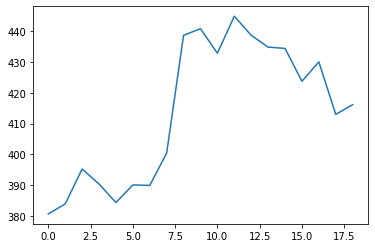

In [19]:
plt.plot(list)

### Generar tabla principal de variables
En esta tabla cada registro representa un valor en un periodo determinado. Podemos partir de balance_filtrado y crear una referencia única a partir de Ticker, Fiscal Year y Fiscal Period.

In [20]:
balance_filtrado = balance_filtrado.astype({'Fiscal Year':str})

In [21]:
balance_filtrado['Ref'] = balance_filtrado['Ticker'] + balance_filtrado['Fiscal Year'] + balance_filtrado['Fiscal Period']

In [22]:
balance_filtrado.index = balance_filtrado.Ref
balance_filtrado.head()

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),"Cash, Cash Equivalents & Short Term Investments",Interbank Assets,Short & Long Term Investments,Accounts & Notes Receivable,Net Loans,Net Fixed Assets,Total Assets,Total Deposits,Short Term Debt,Long Term Debt,Total Liabilities,Preferred Equity,Share Capital & Additional Paid-In Capital,Treasury Stock,Retained Earnings,Total Equity,Total Liabilities & Equity,Ref
Ref,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BAC2011Q3,BAC,71941,USD,2011,Q3,2011-09-30,2011-11-03,2011-11-03,1.011628e+10,1.046440e+10,82865000000,2.499980e+11,624497000000,NaN,8.974490e+11,1.355200e+10,2219628000000,1.041353e+12,3.500110e+11,3.989650e+11,1989376000000,1.948000e+10,153801000000,NaN,5.904300e+10,230252000000,2219628000000,BAC2011Q3
BAC2011Q4,BAC,71941,USD,2011,Q4,2011-12-31,2012-02-23,2013-02-28,1.028341e+10,1.027862e+10,120102000000,2.111830e+11,579762000000,NaN,8.924170e+11,1.363700e+10,2129046000000,1.033041e+12,3.110700e+11,3.722650e+11,1898945000000,1.839700e+10,156621000000,NaN,6.052000e+10,230101000000,2129046000000,BAC2011Q4
BAC2012Q1,BAC,71941,USD,2012,Q1,2012-03-31,2012-05-03,2012-05-03,1.065137e+10,1.076192e+10,128792000000,2.257840e+11,620550000000,NaN,8.700830e+11,1.310400e+10,2181449000000,1.041311e+12,3.681590e+11,3.549120e+11,1948950000000,1.878800e+10,157973000000,NaN,6.073400e+10,232499000000,2181449000000,BAC2012Q1
BAC2012Q2,BAC,71941,USD,2012,Q2,2012-06-30,2012-08-02,2012-08-02,1.077570e+10,1.155601e+10,123717000000,2.261160e+11,622231000000,NaN,8.620270e+11,1.265300e+10,2160854000000,1.035225e+12,4.023910e+11,3.018480e+11,1924879000000,1.876200e+10,158001000000,NaN,6.271200e+10,235975000000,2160854000000,BAC2012Q2
BAC2012Q3,BAC,71941,USD,2012,Q3,2012-09-30,2012-11-02,2012-11-02,1.077617e+10,1.077617e+10,106415000000,2.340340e+11,630752000000,NaN,8.668020e+11,1.243600e+10,2166162000000,1.063307e+12,3.813700e+11,2.865340e+11,1927556000000,1.876800e+10,158066000000,NaN,6.258300e+10,238606000000,2166162000000,BAC2012Q3


In [23]:
resultados_filtrado = resultados_filtrado.astype({'Fiscal Year':str})

In [24]:
resultados_filtrado['Ref'] = resultados_filtrado['Ticker'] + resultados_filtrado['Fiscal Year'] + resultados_filtrado['Fiscal Period']

In [25]:
resultados_filtrado.index = resultados_filtrado.Ref
resultados_filtrado.head()

,Ticker,Fiscal Year,Fiscal Period,Revenue,Provision for Loan Losses,Net Revenue after Provisions,Total Non-Interest Expense,Operating Income (Loss),Non-Operating Income (Loss),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common),Ref
Ref,,,,,,,,,,,,,,,,
BAC2011Q3,BAC,2011,Q3,28453000000,-3.407000e+09,25046000000,-17437000000,7609000000,NaN,7433000000,-1.201000e+09,6232000000,NaN,6232000000,5889000000,BAC2011Q3
BAC2011Q4,BAC,2011,Q4,24888000000,-2.934000e+09,21954000000,-18840000000,3114000000,NaN,2432000000,-4.410000e+08,1991000000,NaN,1991000000,1584000000,BAC2011Q4
BAC2012Q1,BAC,2012,Q1,22278000000,-2.418000e+09,19860000000,-19141000000,719000000,NaN,719000000,-6.600000e+07,653000000,NaN,653000000,328000000,BAC2012Q1
BAC2012Q2,BAC,2012,Q2,21968000000,-1.773000e+09,20195000000,-17048000000,3147000000,NaN,3147000000,-6.840000e+08,2463000000,NaN,2463000000,2098000000,BAC2012Q2
BAC2012Q3,BAC,2012,Q3,20428000000,-1.774000e+09,18654000000,-17544000000,1110000000,NaN,1110000000,-7.700000e+08,340000000,NaN,340000000,-33000000,BAC2012Q3


### Merge de tablas balance y resultados

In [26]:
balance_filtrado.drop('Ref', axis=1, inplace=True)
resultados_filtrado.drop(['Ref','Fiscal Year', 'Fiscal Period','Ticker'], axis=1, inplace=True)

In [27]:
mergedbalres=balance_filtrado.merge(resultados_filtrado, on= 'Ref', how='left')

In [28]:
mergedbalres

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),"Cash, Cash Equivalents & Short Term Investments",Interbank Assets,Short & Long Term Investments,Accounts & Notes Receivable,Net Loans,Net Fixed Assets,Total Assets,Total Deposits,Short Term Debt,Long Term Debt,Total Liabilities,Preferred Equity,Share Capital & Additional Paid-In Capital,Treasury Stock,Retained Earnings,Total Equity,Total Liabilities & Equity,Revenue,Provision for Loan Losses,Net Revenue after Provisions,Total Non-Interest Expense,Operating Income (Loss),Non-Operating Income (Loss),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common)
Ref,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BAC2011Q3,BAC,71941,USD,2011,Q3,2011-09-30,2011-11-03,2011-11-03,1.011628e+10,1.046440e+10,82865000000,2.499980e+11,624497000000,NaN,8.974490e+11,1.355200e+10,2219628000000,1.041353e+12,3.500110e+11,3.989650e+11,1989376000000,1.948000e+10,153801000000,NaN,5.904300e+10,230252000000,2219628000000,28453000000,-3.407000e+09,25046000000,-17437000000,7609000000,NaN,7433000000,-1.201000e+09,6232000000,NaN,6232000000,5889000000
BAC2011Q4,BAC,71941,USD,2011,Q4,2011-12-31,2012-02-23,2013-02-28,1.028341e+10,1.027862e+10,120102000000,2.111830e+11,579762000000,NaN,8.924170e+11,1.363700e+10,2129046000000,1.033041e+12,3.110700e+11,3.722650e+11,1898945000000,1.839700e+10,156621000000,NaN,6.052000e+10,230101000000,2129046000000,24888000000,-2.934000e+09,21954000000,-18840000000,3114000000,NaN,2432000000,-4.410000e+08,1991000000,NaN,1991000000,1584000000
BAC2012Q1,BAC,71941,USD,2012,Q1,2012-03-31,2012-05-03,2012-05-03,1.065137e+10,1.076192e+10,128792000000,2.257840e+11,620550000000,NaN,8.700830e+11,1.310400e+10,2181449000000,1.041311e+12,3.681590e+11,3.549120e+11,1948950000000,1.878800e+10,157973000000,NaN,6.073400e+10,232499000000,2181449000000,22278000000,-2.418000e+09,19860000000,-19141000000,719000000,NaN,719000000,-6.600000e+07,653000000,NaN,653000000,328000000
BAC2012Q2,BAC,71941,USD,2012,Q2,2012-06-30,2012-08-02,2012-08-02,1.077570e+10,1.155601e+10,123717000000,2.261160e+11,622231000000,NaN,8.620270e+11,1.265300e+10,2160854000000,1.035225e+12,4.023910e+11,3.018480e+11,1924879000000,1.876200e+10,158001000000,NaN,6.271200e+10,235975000000,2160854000000,21968000000,-1.773000e+09,20195000000,-17048000000,3147000000,NaN,3147000000,-6.840000e+08,2463000000,NaN,2463000000,2098000000
BAC2012Q3,BAC,71941,USD,2012,Q3,2012-09-30,2012-11-02,2012-11-02,1.077617e+10,1.077617e+10,106415000000,2.340340e+11,630752000000,NaN,8.668020e+11,1.243600e+10,2166162000000,1.063307e+12,3.813700e+11,2.865340e+11,1927556000000,1.876800e+10,158066000000,NaN,6.258300e+10,238606000000,2166162000000,20428000000,-1.774000e+09,18654000000,-17544000000,1110000000,NaN,1110000000,-7.700000e+08,340000000,NaN,340000000,-33000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZION2018Q1,ZION,378250,USD,2018,Q1,2018-03-31,2018-05-09,2018-05-09,1.967220e+08,2.102430e+08,470000000,1.413000e+09,15807000000,NaN,4.461000e+10,1.098000e+09,66481000000,5.296300e+10,4.867000e+09,3.830000e+08,58837000000,5.660000e+08,4346000000,NaN,2.999000e+09,7644000000,66481000000,680000000,4.000000e+07,720000000,-412000000,308000000,NaN,308000000,-7.000000e+07,238000000,NaN,238000000,231000000
ZION2018Q2,ZION,378250,USD,2018,Q2,2018-06-30,2018-08-08,2018-08-08,1.955830e+08,2.092470e+08,468000000,1.256000e+09,15712000000,NaN,4.474000e+10,1.099000e+09,66457000000,5.358000e+10,4.158000e+09,3.830000e+08,58836000000,5.660000e+08,4231000000,NaN,3.139000e+09,7621000000,66457000000,686000000,-5.000000e+06,681000000,-428000000,253000000,NaN,253000000,-5.600000e+07,197000000,NaN,197000000,187000000
ZION2018Q3,ZION,378250,USD,2018,Q3,2018-09-30,2018-11-07,2018-11-07,1.929730e+08,2.0576

In [29]:
companies[companies.Ticker=='WFC']

,Ticker,SimFinId,Company Name,IndustryId
1818,WFC,58953,WELLS FARGO & COMPANY/MN,104002


In [30]:
mergedbalres.groupby('Fiscal Year').count()

,Ticker,SimFinId,Currency,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),"Cash, Cash Equivalents & Short Term Investments",Interbank Assets,Short & Long Term Investments,Accounts & Notes Receivable,Net Loans,Net Fixed Assets,Total Assets,Total Deposits,Short Term Debt,Long Term Debt,Total Liabilities,Preferred Equity,Share Capital & Additional Paid-In Capital,Treasury Stock,Retained Earnings,Total Equity,Total Liabilities & Equity,Revenue,Provision for Loan Losses,Net Revenue after Provisions,Total Non-Interest Expense,Operating Income (Loss),Non-Operating Income (Loss),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common)
Fiscal Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,4,4,4,4,4,4,4,4,4,4,2,4,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4,2,4,4
2009,38,38,38,38,38,38,38,38,38,38,30,38,2,35,30,38,38,38,38,38,34,38,38,38,38,38,38,35,38,38,38,3,38,38,38,8,38,38
2010,85,85,85,85,85,85,85,82,82,85,66,85,4,81,73,85,85,82,77,85,63,85,74,85,85,85,85,81,85,85,85,6,85,85,85,13,85,85
2011,141,141,141,141,141,141,141,137,137,141,99,141,5,137,129,141,141,126,114,141,110,141,112,141,141,141,141,134,141,141,141,5,141,141,141,15,141,141
2012,159,159,159,159,159,159,159,155,155,159,105,159,6,155,147,159,159,142,126,159,115,159,115,159,159,159,159,152,159,159,159,4,159,159,159,16,159,159
2013,168,168,168,168,168,168,168,164,164,168,108,168,11,165,156,168,168,149,132,168,119,168,122,168,168,168,168,161,168,168,168,8,168,168,168,20,168,168
2014,170,170,170,170,170,170,170,166,166,170,110,170,11,167,158,170,170,154,134,170,127,170,128,170,170,170,170,166,170,170,170,7,170,170,170,24,170,170
2015,178,178,178,178,178,178,178,174,174,178,116,178,10,178,166,178,178,161,139,178,138,178,133,178,178,178,178,174,178,178,178,4,178,178,178,13,178,178
2016,183,183,183,183,183,183,183,179,179,183,124,183,12,183,171,183,183,166,143,183,137,183,134,183,183,183,183,179,183,183,183,4,183,183,183,17,183,183


### Índice y consideración sobre el precio

Para nuestro análisis disponemos del campo 'Adj. Close', que se trata del precio de cierre descontando los efectos de acciones corporativas como pago de dividendos, splits, etc., ideal para un análisis a largo plazo como el nuestro.
Para el etiquetado de nuestros registros, deberemos obtener un índice del sector bancario del tipo 'Total return', calculado también de forma que se excluyen los efectos de los pagos de dvidendos u otras acciones.
Podemos probar con el Dow Jones U.S. Banks Index (DJUSBKT).
No hemos encontrado datos fiables de este índice, así que probamos con el Dow Jones U.S. Financials Index, obteniendo información histórica desde 2008 en Yahoo Finance https://finance.yahoo.com/quote/%5EDJUSFN/

In [31]:
# Volcamos en un dataframe los datos obtenidos del índide
Bank_index = pd.read_csv('./datos/DJUSFN.csv', sep=',', index_col='Date')
Bank_index.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,463.364014,463.364014,463.364014,463.364014,463.364014,0.0
2008-01-03,459.412994,459.412994,459.412994,459.412994,459.412994,0.0
2008-01-04,446.221008,446.221008,446.221008,446.221008,446.221008,0.0
2008-01-07,448.487000,448.487000,448.487000,448.487000,448.487000,0.0
2008-01-08,432.351013,432.351013,432.351013,432.351013,432.351013,0.0


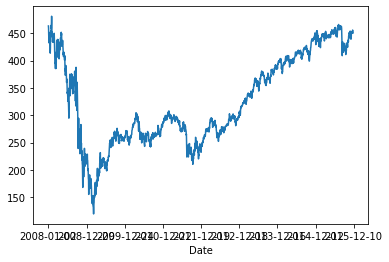

In [32]:
Bank_index['Adj Close'].plot()

## Etiquetado

En este momento disponemos de 3 tablas diferentes:

- mergedbalres
- banks_cotiz
- Bank_index

Para poder asignar a cada trimestre analizado la etiqueta adecuada debemos seguir los siguientes pasos:

    1) Volcar el precio de Bank_index en la fecha de publicación de resultados en cada registro de mergedbalres
    2) Volcar el precio de Bank_index en la fecha de publicación de resultados + 90 días en cada registro de mergedbalres
    3) Volcar el precio de banks_cotiz para el Ticker correspondiente en la fecha de publicación de resultados en cada registro de mergedbalres
    4) Volcar el precio de banks_cotiz para el Ticker correspondiente en la fecha de publicación de resultados + 90 días en cada registro de mergedbalres
    5) Calcular en mergedbalres, para cada registro, la variación porcentual tanto del índice como del Ticker
    6) Comparar ambas variaciones y asignar la etiqueta correspondiente: entre +1% y -1% 'neutro'; más de 1% a favor de Ticker 'mejor'; menos de -1% con respecto índice 'peor'.

### 1) Precio de Bank_index a mergedbalres en d (fecha de publicación)

In [85]:
for i in range(0,len(banks_cotiz),1):
    a = banks_cotiz.Date[i]
    banks_cotiz.year[i]=a[:4]
    if i%5000==0:
        print (i)

/home/pipe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000


In [87]:
banks_cotiz.groupby('year').count()

,Ticker,SimFinId,Date,Open,Low,High,Close,Adj. Close,Dividend,Volume
year,,,,,,,,,,
2007,12223,12223,12223,12223,12223,12223,12223,12223,159,12223
2008,12743,12743,12743,12743,12743,12743,12743,12743,170,12743
2009,12867,12867,12867,12867,12867,12867,12867,12867,162,12867
2010,13102,13102,13102,13102,13102,13102,13102,13102,153,13102
2011,13104,13104,13104,13104,13104,13104,13104,13104,153,13104
2012,12999,12999,12999,12999,12999,12999,12999,12999,160,12999
2013,13266,13266,13266,13266,13266,13266,13266,13266,166,13266
2014,13425,13425,13425,13425,13425,13425,13425,13425,182,13425
2015,13750,13750,13750,13750,13750,13750,13750,13750,187,13750


In [60]:
cotizacion[2000:3000]

,Ticker,SimFinId,Date,Open,Low,High,Close,Adj. Close,Dividend,Volume,year
2000,GOOG,18,2014-12-11,527.80,527.100,533.920,528.34,526.89,NaN,1610800,2014
2001,GOOG,18,2014-12-12,523.51,518.660,528.500,518.66,517.24,NaN,1994500,2014
2002,GOOG,18,2014-12-15,522.74,513.270,523.100,513.80,512.39,NaN,2813400,2014
2003,GOOG,18,2014-12-16,511.56,489.000,513.050,495.39,494.03,NaN,3964200,2014
2004,GOOG,18,2014-12-17,497.00,496.810,507.000,504.89,503.51,NaN,2883100,2014
...,...,...,...,...,...,...,...,...,...,...,...
2995,GOOG,18,2018-11-23,1030.00,1022.399,1037.590,1023.88,1023.88,NaN,691500,NaN
2996,GOOG,18,2018-11-26,1038.35,1033.910,1049.310,1048.62,1048.62,NaN,1942800,NaN
2997,GOOG,18,2018-11-27,1041.00,1038.490,1057.580,1044.41,1044.41,NaN,1803200,NaN
2998,GOOG,18,2018-11-28,1048.76,1035.760,1086.840,1086.23,1086.23,NaN,2475400,NaN
